In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.models import Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
heartData=pd.read_csv("/content/drive/MyDrive/heartTransformer/Dataset/heartDatset.csv")



In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
heartData['Sex'] = label_encoder.fit_transform(heartData['Sex'])

print("After encoding:")
print(heartData['Sex'].head())

After encoding:
0    1
1    1
2    0
3    1
4    1
Name: Sex, dtype: int64


In [7]:
heartData['Blood Pressure'] = heartData['Blood Pressure'].str.replace('/', '.')

# Display the first few rows of the 'blood_pressure' column after replacement
print("After replacement:")
print(heartData['Blood Pressure'].head())

After replacement:
0     158.88
1     165.93
2     174.99
3    163.100
4      91.88
Name: Blood Pressure, dtype: object


In [8]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
heartData['Diet'] = label_encoder.fit_transform(heartData['Diet'])

print("After encoding:")
print(heartData['Diet'].head())

After encoding:
0    0
1    2
2    1
3    0
4    2
Name: Diet, dtype: int64


In [9]:
X = heartData.iloc[:, :-1].values
y = heartData.iloc[:, -1].values

Text(0.5, 1.0, 'Class Distribuition for Heart Attack Risk')

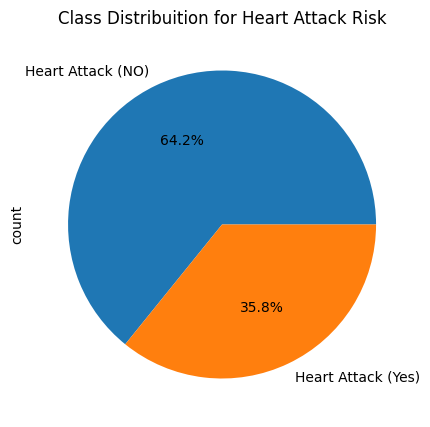

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
labels = ['Heart Attack (NO)', 'Heart Attack (Yes)']
heartData['Heart Attack Risk'].value_counts().plot(kind='pie',labels=labels,autopct='%1.1f%%')
plt.title('Class Distribuition for Heart Attack Risk')

In [10]:
from imblearn.over_sampling import SMOTE
import numpy as np

smote= SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X, y)

In [11]:
X_resampled.shape

(11248, 21)

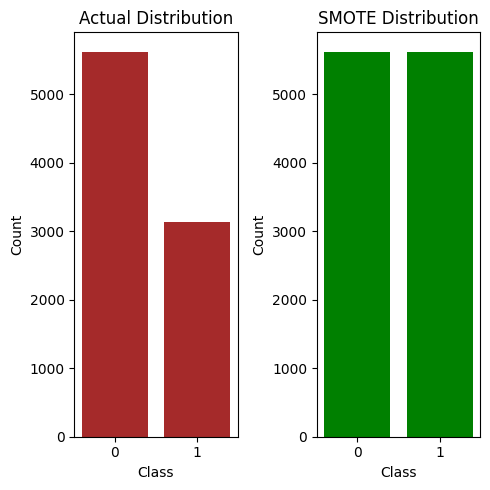

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 5))

# First bar graph
ax1.bar(Counter(y).keys(), Counter(y).values(), color='brown')
ax1.set_title('Actual Distribution')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_xticks(np.unique(y))

# Second bar graph
ax2.bar(Counter(y_resampled).keys(), Counter(y_resampled).values(), color='green')
ax2.set_title('SMOTE Distribution')
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')
ax2.set_xticks(np.unique(y_resampled))

# Adjust layout
plt.tight_layout()
plt.show()


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [13]:
print(X_train.shape)
print(X_val.shape)

(10123, 21)
(1125, 21)


In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
def create_model(input_shape, embed_dim, num_heads, ff_dim, num_classes):
    inputs = Input(shape=input_shape)
    # Expand dimensions to add the sequence length dimension
    x = tf.expand_dims(inputs, axis=1)
    x = Dense(embed_dim)(x)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(20, activation="relu")(x)
    x = Dropout(0.1)(x)
    outputs = Dense(num_classes, activation="sigmoid")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
# Parameters
input_shape = (21,)  # 21 input columns
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
num_classes = 1  # Binary classification

model = create_model(input_shape, embed_dim, num_heads, ff_dim, num_classes)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100
317/317 [==============================] - 7s 11ms/step - loss: 0.7124 - accuracy: 0.5031 - val_loss: 0.6955 - val_accuracy: 0.5164
Epoch 2/100
317/317 [==============================] - 2s 6ms/step - loss: 0.6949 - accuracy: 0.5231 - val_loss: 0.6952 - val_accuracy: 0.5013
Epoch 3/100
317/317 [==============================] - 2s 6ms/step - loss: 0.6891 - accuracy: 0.5406 - val_loss: 0.6936 - val_accuracy: 0.5147
Epoch 4/100
317/317 [==============================] - 2s 6ms/step - loss: 0.6884 - accuracy: 0.5423 - val_loss: 0.6884 - val_accuracy: 0.5511
Epoch 5/100
317/317 [==============================] - 2s 6ms/step - loss: 0.6843 - accuracy: 0.5545 - val_loss: 0.6850 - val_accuracy: 0.5467
Epoch 6/100
317/317 [==============================] - 2s 6ms/step - loss: 0.6816 - accuracy: 0.5538 - val_loss: 0.6780 - val_accuracy: 0.5840
Epoch 7/100
317/317 [==============================] - 2s 7ms/step - loss: 0.6773 - accuracy: 0.5679 - val_loss: 0.6766 - val_accuracy: 0.560

In [ ]:
history.history['accuracy']

[0.503111720085144,
 0.5230662822723389,
 0.5405512452125549,
 0.5423293709754944,
 0.5544798970222473,
 0.553788423538208,
 0.5679146647453308,
 0.5823372602462769,
 0.5859922766685486,
 0.5964635014533997,
 0.6058480739593506,
 0.6116763949394226,
 0.6130593419075012,
 0.614639937877655,
 0.6280747056007385,
 0.6332114934921265,
 0.6313346028327942,
 0.6334090828895569,
 0.6444729566574097,
 0.6474365592002869,
 0.6516842842102051,
 0.6506964564323425,
 0.6572162508964539,
 0.6587967872619629,
 0.6508939862251282,
 0.661068856716156,
 0.6679837703704834,
 0.6689716577529907,
 0.6652178168296814,
 0.6675886511802673,
 0.6703546643257141,
 0.6719352006912231,
 0.6707497835159302,
 0.6721327900886536,
 0.6786525845527649,
 0.6779610514640808,
 0.6811221837997437,
 0.6794428825378418,
 0.6841845512390137,
 0.6872468590736389,
 0.6893213391304016,
 0.6910994648933411,
 0.6872468590736389,
 0.687641978263855,
 0.6954460144042969,
 0.6940630078315735,
 0.6994962096214294,
 0.698113203048706

In [ ]:
history.history['val_accuracy']

[0.5164444446563721,
 0.5013333559036255,
 0.5146666765213013,
 0.551111102104187,
 0.54666668176651,
 0.5839999914169312,
 0.5600000023841858,
 0.5751110911369324,
 0.574222207069397,
 0.5759999752044678,
 0.5893333554267883,
 0.6008889079093933,
 0.5866666436195374,
 0.6097777485847473,
 0.5804444551467896,
 0.6053333282470703,
 0.6186666488647461,
 0.6186666488647461,
 0.6124444603919983,
 0.6266666650772095,
 0.6337777972221375,
 0.6391111016273499,
 0.6337777972221375,
 0.6426666378974915,
 0.6355555653572083,
 0.6399999856948853,
 0.6391111016273499,
 0.6408888697624207,
 0.6355555653572083,
 0.656000018119812,
 0.6382222175598145,
 0.6524444222450256,
 0.6435555815696716,
 0.653333306312561,
 0.6551111340522766,
 0.6568889021873474,
 0.6408888697624207,
 0.6524444222450256,
 0.6337777972221375,
 0.6426666378974915,
 0.6515555381774902,
 0.6506666541099548,
 0.6471111178398132,
 0.6648889183998108,
 0.6613333225250244,
 0.6364444494247437,
 0.6480000019073486,
 0.6622222065925598

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


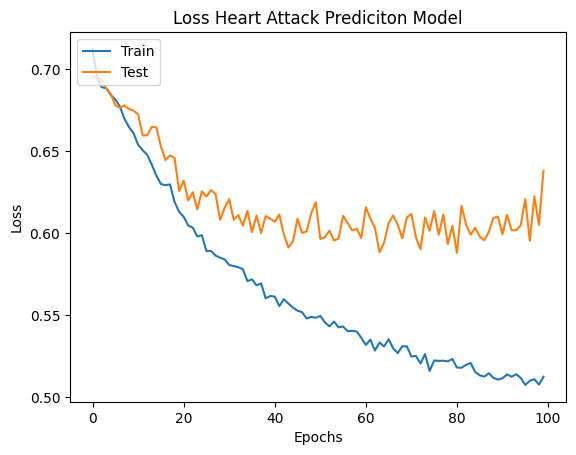

In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Heart Attack Prediciton Model')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend([ 'Train' , 'Test' ], loc= 'upper left' )
plt.show()

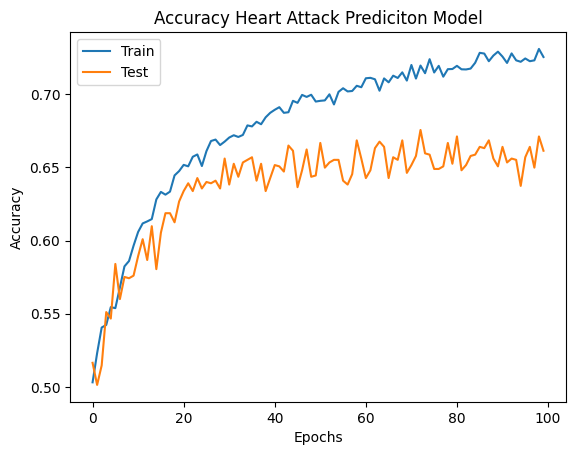

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Heart Attack Prediciton Model')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend([ 'Train' , 'Test' ], loc= 'upper left' )
plt.show()

In [ ]:
y_pred = model.predict(X_val)

36/36 [==============================] - 2s 5ms/step


In [ ]:
y_pred

array([[0.46342927],
       [0.5308316 ],
       [0.97706676],
       ...,
       [0.17019211],
       [0.50500745],
       [0.4038725 ]], dtype=float32)

In [ ]:
predicted = (y_pred >= 0.5).astype(int)

In [ ]:
predicted

array([[0],
       [1],
       [1],
       ...,
       [0],
       [1],
       [0]])

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val,predicted)

array([[424, 132],
       [249, 320]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val,predicted))

              precision    recall  f1-score   support

           0       0.63      0.76      0.69       556
           1       0.71      0.56      0.63       569

    accuracy                           0.66      1125
   macro avg       0.67      0.66      0.66      1125
weighted avg       0.67      0.66      0.66      1125



In [ ]:
cm=classification_report(y_val,predicted)

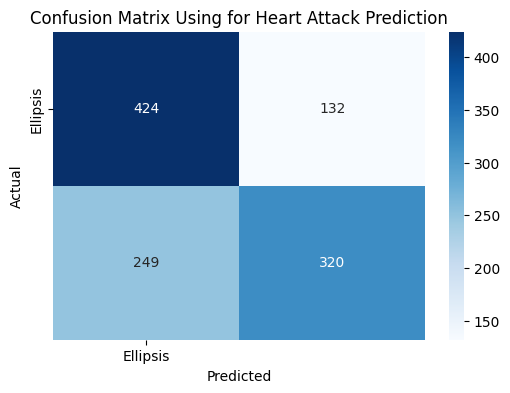

In [ ]:
import seaborn as sns
cm = confusion_matrix(y_val,predicted)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[...], yticklabels=[...])  # Replace [...] with your class labels
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Using for Heart Attack Prediction')
plt.show()

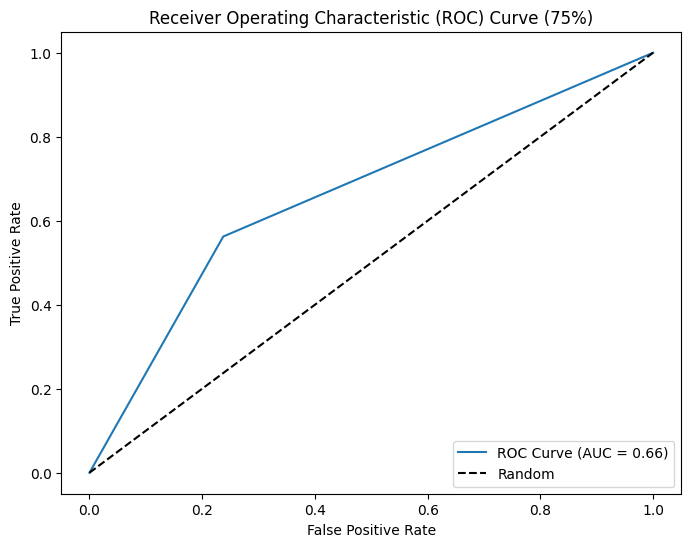

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_val,predicted)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (75%)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
df = pd.DataFrame(X_train).head(20)
#df = pd.DataFrame(X_testNormal)
df.to_csv("/content/drive/MyDrive/heartTransformer//output//Xtrain.csv")

In [ ]:
df = pd.DataFrame(y_train).head(20)
#df = pd.DataFrame(X_testNormal)
df.to_csv("/content/drive/MyDrive/heartTransformer//output//y_train.csv")

In [ ]:
df = pd.DataFrame(X_val).head(20)
#df = pd.DataFrame(X_testNormal)
df.to_csv("/content/drive/MyDrive/heartTransformer//output//X_test.csv")

In [ ]:
df = pd.DataFrame(y_val).head(20)
#df = pd.DataFrame(X_testNormal)
df.to_csv("/content/drive/MyDrive/heartTransformer//output//y_test.csv")

In [ ]:
df = pd.DataFrame(y_pred).head(20)
#df = pd.DataFrame(X_testNormal)
df.to_csv("/content/drive/MyDrive/heartTransformer//y_predScore.csv")

In [ ]:
df = pd.DataFrame(predicted).head(20)
#df = pd.DataFrame(X_testNormal)
df.to_csv("/content/drive/MyDrive/heartTransformer//output//predicted.csv")

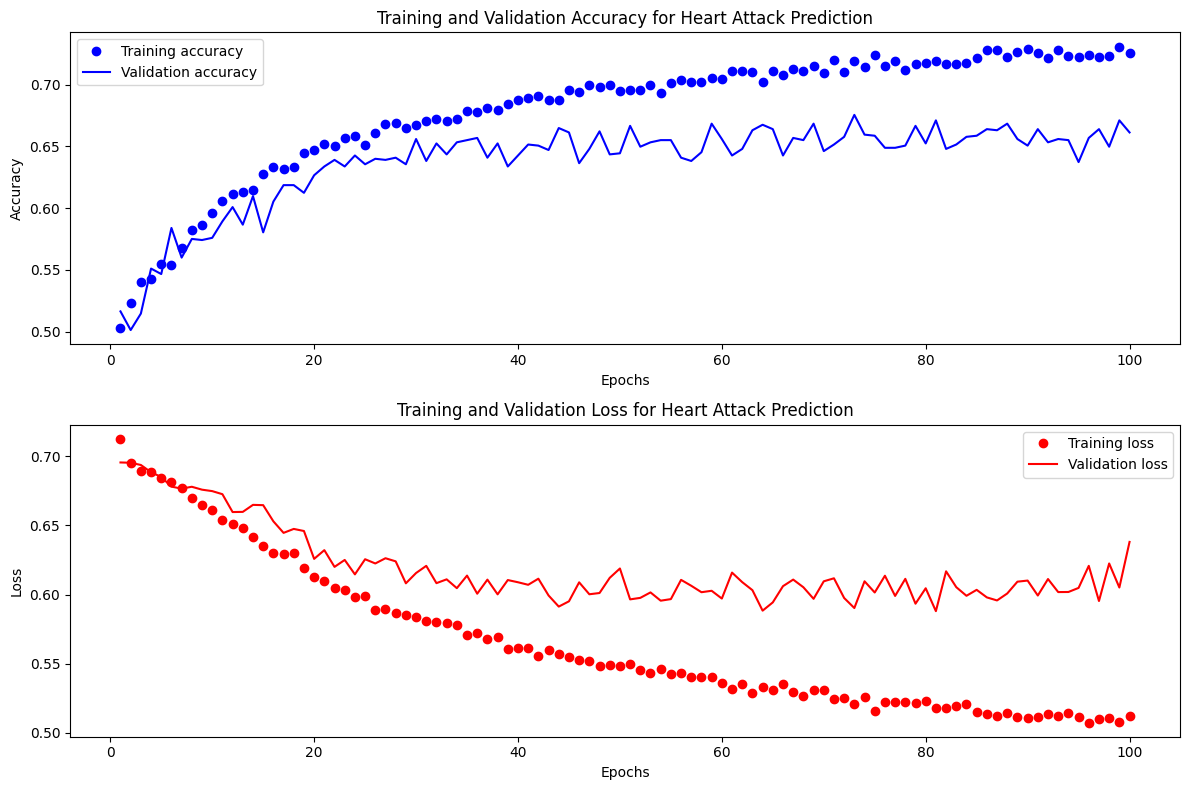

In [ ]:
# Extract history data
history_dict = history.history
train_loss = history_dict['loss']
train_accuracy = history_dict['accuracy']
val_loss = history_dict['val_loss']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# Plotting
plt.figure(figsize=(12, 8))

# Plot accuracy
plt.subplot(2, 1, 1)
plt.plot(epochs, train_accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy for Heart Attack Prediction')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(2, 1, 2)
plt.plot(epochs, train_loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss for Heart Attack Prediction')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_val,predicted)

# Print the MAE
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 0.33866666666666667


Text(0.5, 0, '')

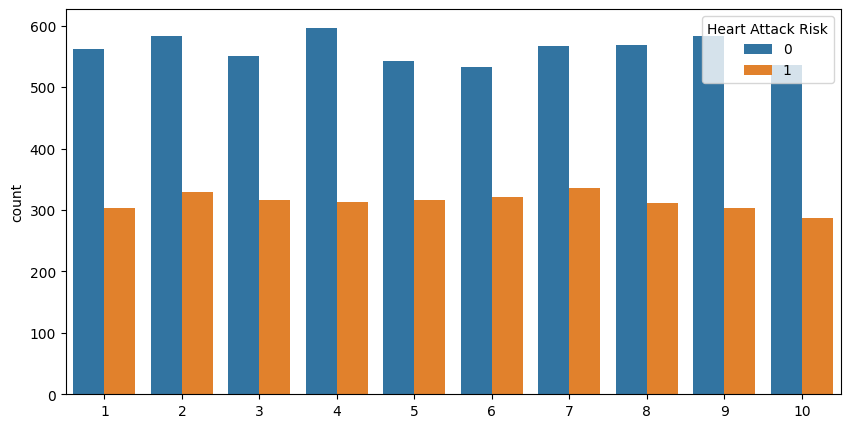

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
plt.figure(figsize=(10,5))
sns.countplot(data=heartData, x='Stress Level', hue='Heart Attack Risk')
plt.xlabel('')

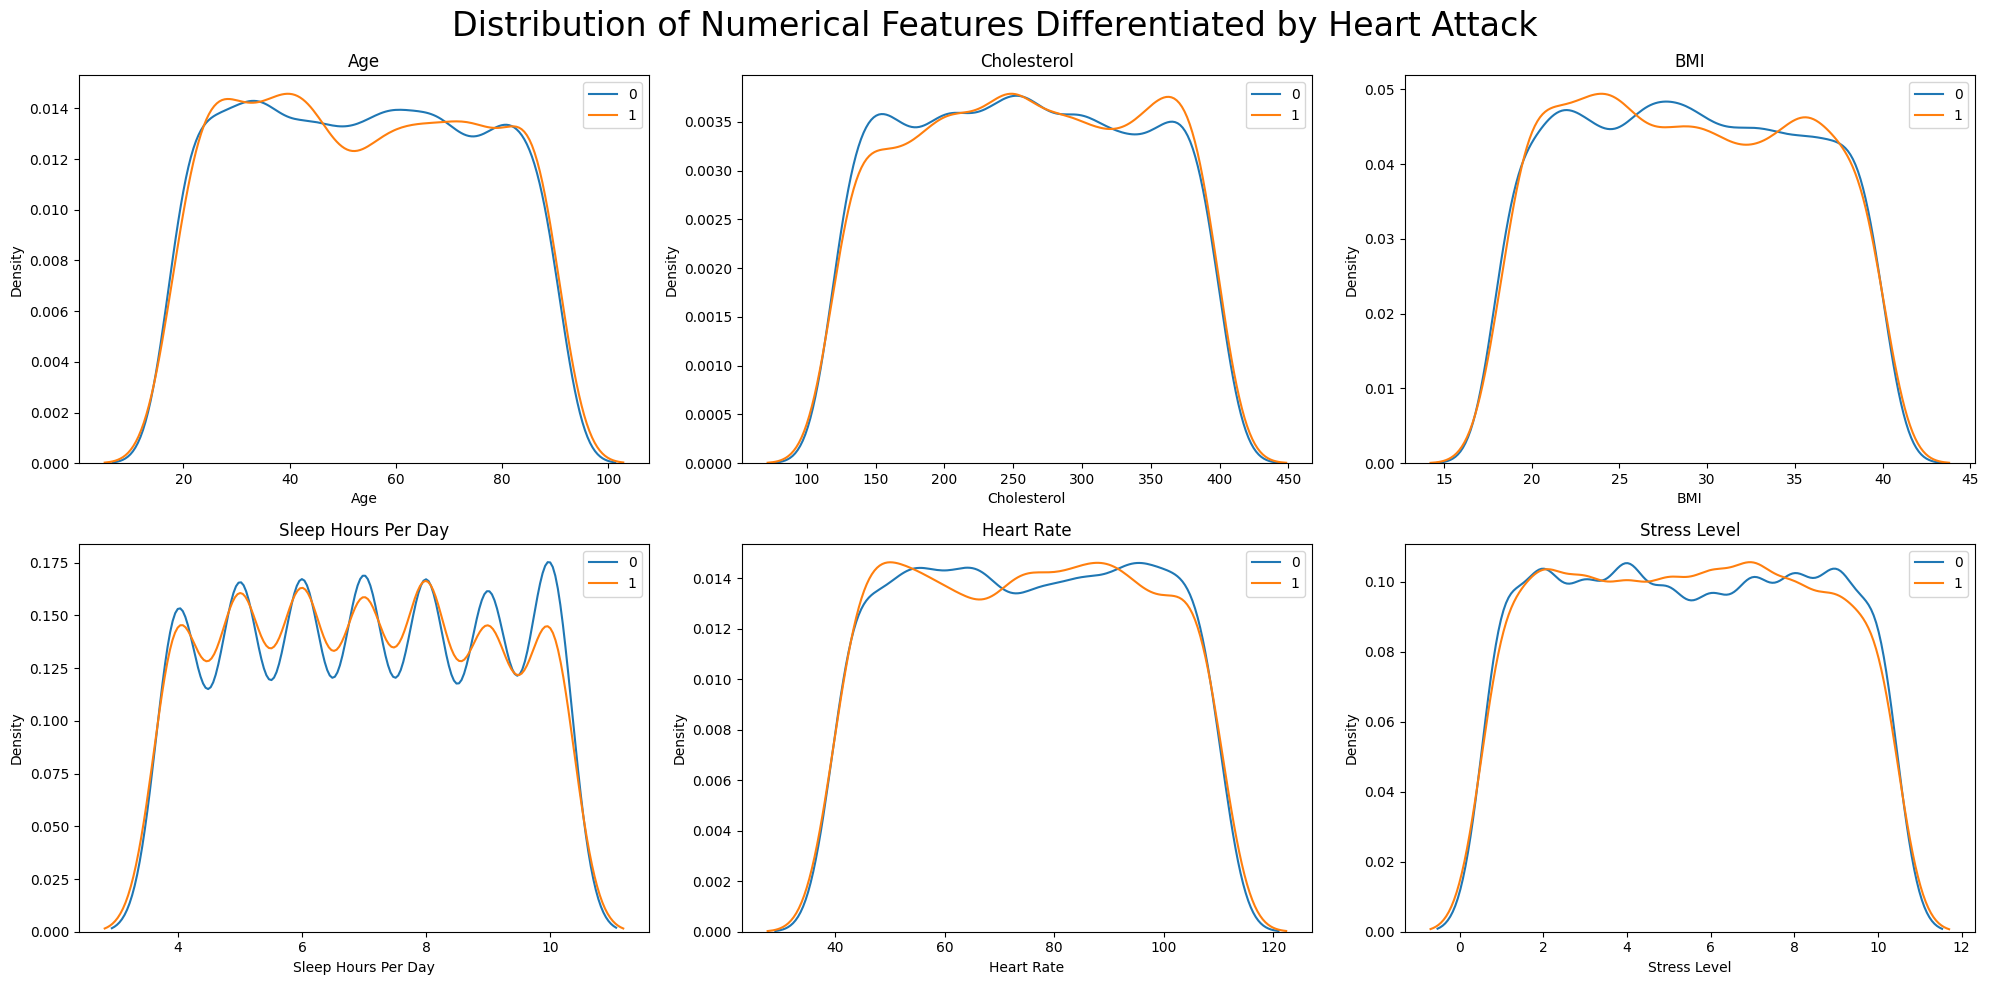

In [ ]:
num_cols=['Age','Cholesterol','BMI','Sleep Hours Per Day','Heart Rate','Stress Level']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

for i, variable in enumerate(num_cols):
    for target_category in heartData['Heart Attack Risk'].unique():
        sns.kdeplot(data=heartData[heartData['Heart Attack Risk'] == target_category][variable], ax=axes[i//3, i%3], label=target_category)
    axes[i//3, i%3].set_title(variable)
    axes[i//3, i%3].legend()


plt.suptitle('Distribution of Numerical Features Differentiated by Heart Attack',fontsize=24)
plt.tight_layout()

plt.show()

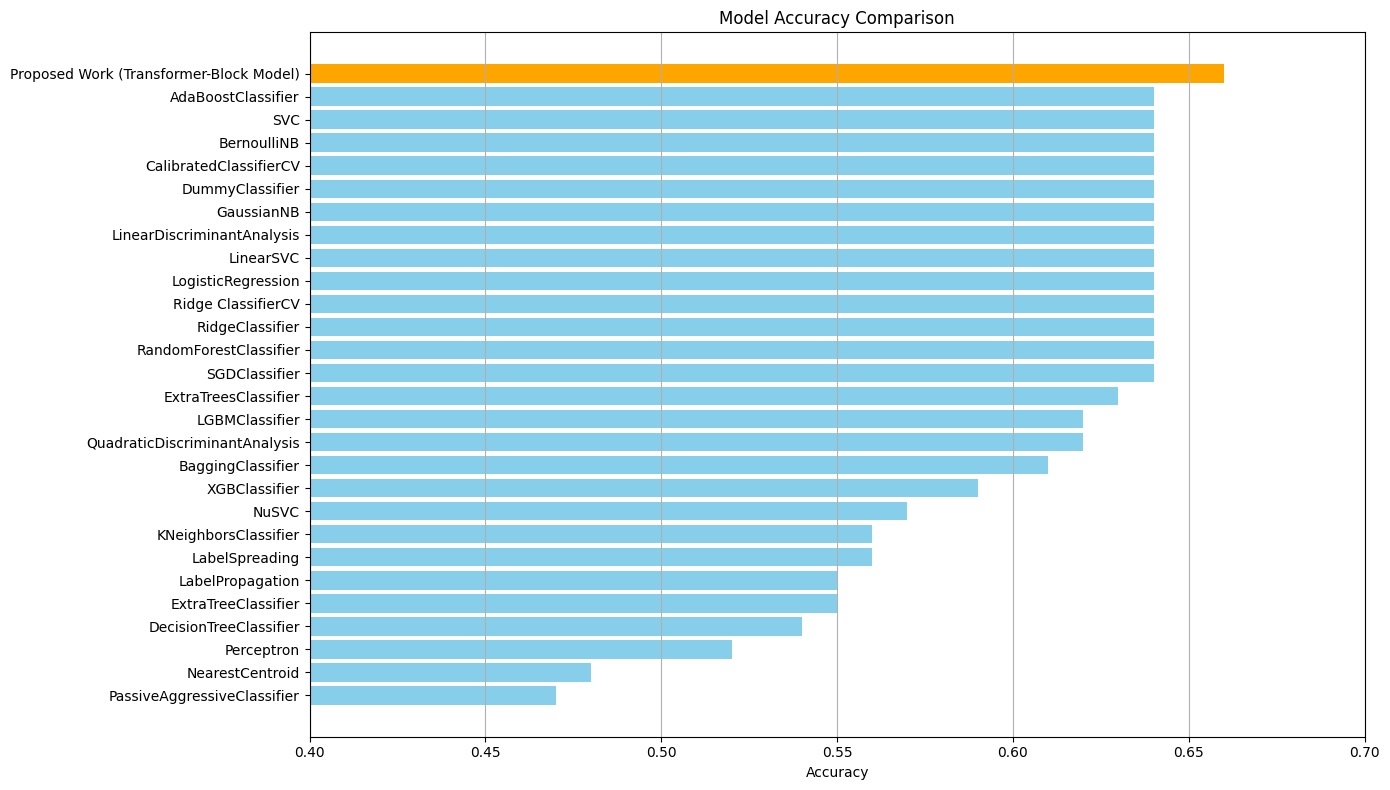

In [14]:
import matplotlib.pyplot as plt

# Data
models = [
    "PassiveAggressiveClassifier", "NearestCentroid", "Perceptron",
    "DecisionTreeClassifier", "ExtraTreeClassifier", "LabelPropagation",
    "LabelSpreading", "KNeighborsClassifier", "NuSVC", "XGBClassifier",
    "BaggingClassifier", "QuadraticDiscriminantAnalysis", "LGBMClassifier",
    "ExtraTreesClassifier", "SGDClassifier", "RandomForestClassifier",
    "RidgeClassifier", "Ridge ClassifierCV", "LogisticRegression",
    "LinearSVC", "LinearDiscriminantAnalysis", "GaussianNB", "DummyClassifier",
    "CalibratedClassifierCV", "BernoulliNB", "SVC", "AdaBoostClassifier",
    "Proposed Work (Transformer-Block Model)"
]

accuracy = [
    0.47, 0.48, 0.52, 0.54, 0.55, 0.55, 0.56, 0.56, 0.57, 0.59,
    0.61, 0.62, 0.62, 0.63, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64,
    0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.66
]

# Plotting
plt.figure(figsize=(14, 8))
plt.barh(models, accuracy, color='skyblue')
plt.xlabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlim(0.4, 0.7)
plt.grid(axis='x')

# Highlight the proposed model
for index, value in enumerate(accuracy):
    if models[index] == "Proposed Work (Transformer-Block Model)":
        plt.barh(models[index], value, color='orange')

plt.tight_layout()
plt.show()


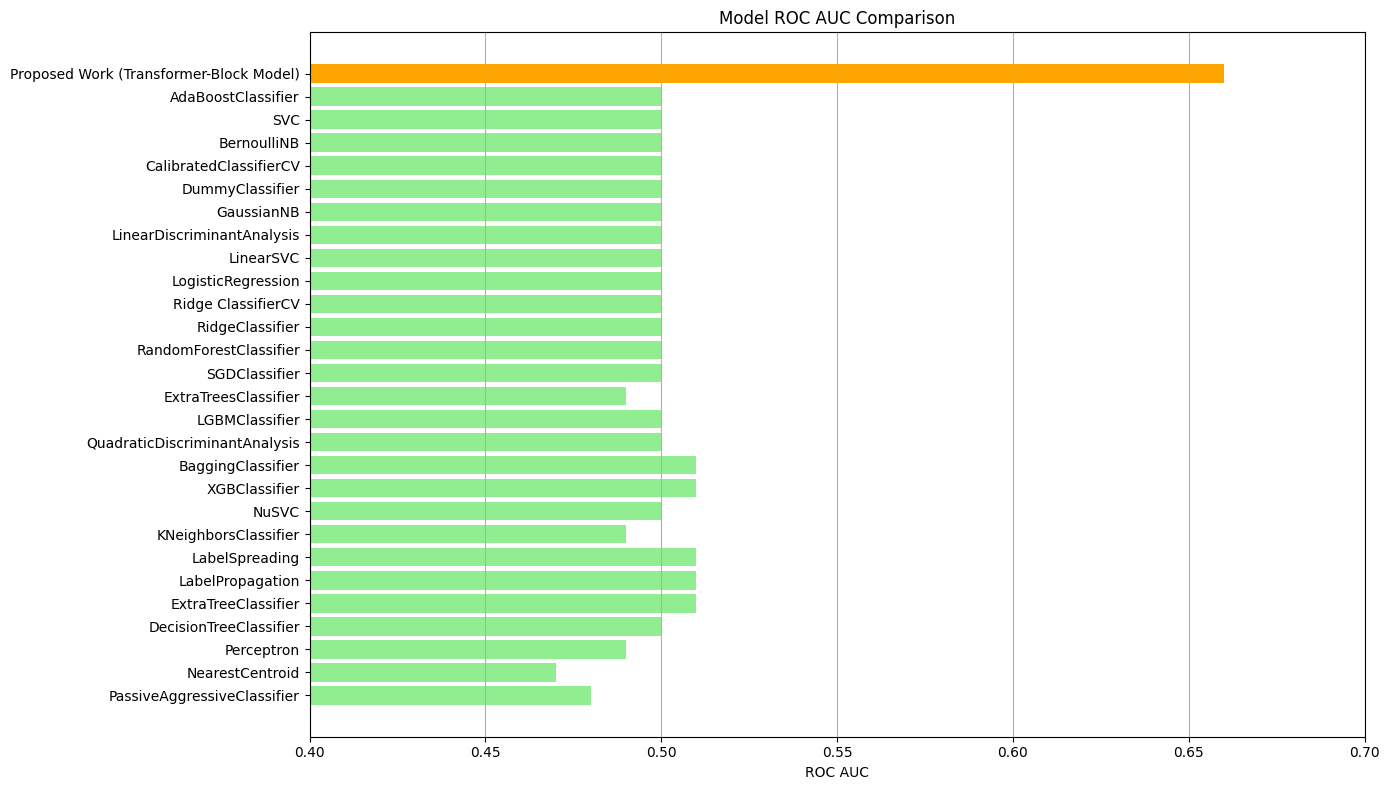

In [15]:
# Data
models_roc_auc = [
    "PassiveAggressiveClassifier", "NearestCentroid", "Perceptron",
    "DecisionTreeClassifier", "ExtraTreeClassifier", "LabelPropagation",
    "LabelSpreading", "KNeighborsClassifier", "NuSVC", "XGBClassifier",
    "BaggingClassifier", "QuadraticDiscriminantAnalysis", "LGBMClassifier",
    "ExtraTreesClassifier", "SGDClassifier", "RandomForestClassifier",
    "RidgeClassifier", "Ridge ClassifierCV", "LogisticRegression",
    "LinearSVC", "LinearDiscriminantAnalysis", "GaussianNB", "DummyClassifier",
    "CalibratedClassifierCV", "BernoulliNB", "SVC", "AdaBoostClassifier",
    "Proposed Work (Transformer-Block Model)"
]

roc_auc = [
    0.48, 0.47, 0.49, 0.5, 0.51, 0.51, 0.51, 0.49, 0.5, 0.51,
    0.51, 0.5, 0.5, 0.49, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
    0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.66
]

# Plotting
plt.figure(figsize=(14, 8))
plt.barh(models_roc_auc, roc_auc, color='lightgreen')
plt.xlabel('ROC AUC')
plt.title('Model ROC AUC Comparison')
plt.xlim(0.4, 0.7)
plt.grid(axis='x')

# Highlight the proposed model
for index, value in enumerate(roc_auc):
    if models_roc_auc[index] == "Proposed Work (Transformer-Block Model)":
        plt.barh(models_roc_auc[index], value, color='orange')

plt.tight_layout()
plt.show()


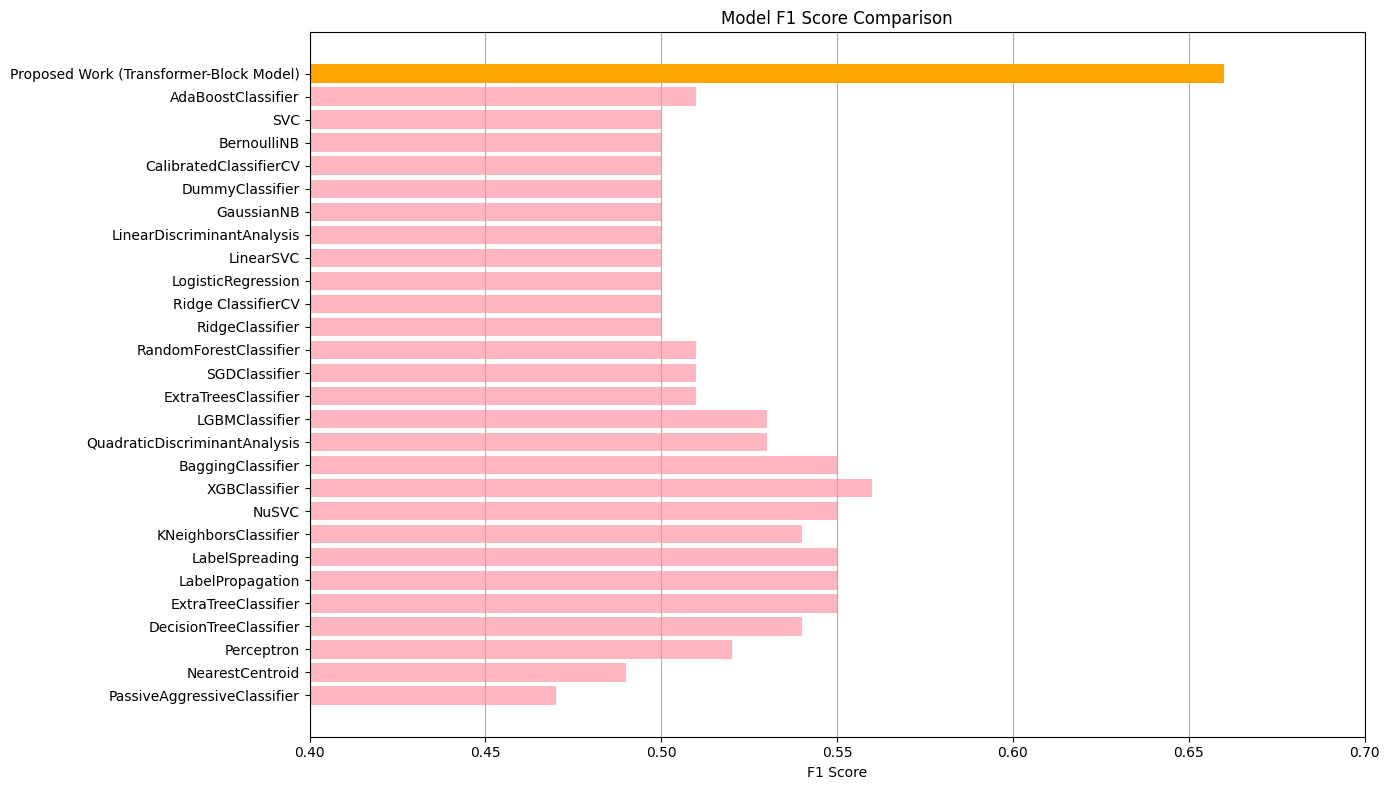

In [17]:
# Data
models_f1_score = [
    "PassiveAggressiveClassifier", "NearestCentroid", "Perceptron",
    "DecisionTreeClassifier", "ExtraTreeClassifier", "LabelPropagation",
    "LabelSpreading", "KNeighborsClassifier", "NuSVC", "XGBClassifier",
    "BaggingClassifier", "QuadraticDiscriminantAnalysis", "LGBMClassifier",
    "ExtraTreesClassifier", "SGDClassifier", "RandomForestClassifier",
    "RidgeClassifier", "Ridge ClassifierCV", "LogisticRegression",
    "LinearSVC", "LinearDiscriminantAnalysis", "GaussianNB", "DummyClassifier",
    "CalibratedClassifierCV", "BernoulliNB", "SVC", "AdaBoostClassifier",
    "Proposed Work (Transformer-Block Model)"
]

f1_score = [
    0.47, 0.49, 0.52, 0.54, 0.55, 0.55, 0.55, 0.54, 0.55, 0.56,
    0.55, 0.53, 0.53, 0.51, 0.51, 0.51, 0.5, 0.5, 0.5, 0.5,
    0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.51, 0.66
]

# Plotting
plt.figure(figsize=(14, 8))
plt.barh(models_f1_score, f1_score, color='lightpink')
plt.xlabel('F1 Score')
plt.title('Model F1 Score Comparison')
plt.xlim(0.4, 0.7)
plt.grid(axis='x')

# Highlight the proposed model
for index, value in enumerate(f1_score):
    if models_f1_score[index] == "Proposed Work (Transformer-Block Model)":
        plt.barh(models_f1_score[index], value, color='orange')

plt.tight_layout()
plt.show()
